# Analysis of titanic survival stats

This is an expansion of the introductory exercise on Kaggle about [predicting the survival of a passenger in titanic](https://www.kaggle.com/c/titanic).

In this notebook I will do my best to apply and consolidate all the knowledge I've learned from Udacity's nanodegree course on ML & some other things that I've picked along the ride.

If my submission on Kaggle becomes a little bit better than my original one I plan to write a dev-friendly tutorial on how to get started with ML, more speficially predictive learning & ML.

In [28]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import scipy

# ensure plots are drawn to this document
%matplotlib inline

train     = pd.read_csv("train.csv")
test      = pd.read_csv("test.csv")

survived  = train["Survived"]
features  = train.drop("Survived", axis = 1)
print("The possible list of features to look at are")
print(list(features.columns.values))

The possible list of features to look at are
['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


As we can see above I'm importing a couple of libraries, these are:

- [numpy](http://www.numpy.org/): A scientific computing library.
- [scikit-learn](http://scikit-learn.org/stable/): A library for machine learning, does not provide a fixed workflow but does give you all the primitives you really need
- [pandas](http://pandas.pydata.org/): A data analysis lib, includes plotting.

Then I'm just loading the data provided from the Kaggle exercises, dropping my "target" from the [Pandas dataframe]() and printing a list of the features that are available to me, from the ones listed above I think for my model I'd just like to keep the following:

- Pclass, socio-economic status
- Age
- Sex
- SibSp, number of siblings/spouses abroad
- Parch, number of parents/children abroad

In [29]:
features = train.drop(["Name", "Ticket", "Fare", "Cabin", "Embarked", "PassengerId", "Survived"], axis = 1)

print("The new list of features is")

relevant_features = list(features.columns.values)
print(relevant_features)

The new list of features is
['Pclass', 'Sex', 'Age', 'SibSp', 'Parch']


Digging deeper into this we now need to "normalize" the dataset into values that are friendlier with the libraries that we're using.

For example, some values are expressed as strings that we should normalize as numbers. Think of it as turning a label for a value into an [enum type](https://en.wikipedia.org/wiki/Enumerated_type)

In [30]:
features["Sex"] = features["Sex"].map({ 'female': 0, 'male': 1 })
features["Age"] = features["Age"].fillna(0)

print("Small subset with new quantified labels")
print(features.head(10))

Small subset with new quantified labels
   Pclass  Sex   Age  SibSp  Parch
0       3    1  22.0      1      0
1       1    0  38.0      1      0
2       3    0  26.0      0      0
3       1    0  35.0      1      0
4       3    1  35.0      0      0
5       3    1   0.0      0      0
6       1    1  54.0      0      0
7       3    1   2.0      3      1
8       3    0  27.0      0      2
9       2    0  14.0      1      0


In [31]:
print("To get a sense of the shape of our data we can look at central measures of tendency")

features.describe()

To get a sense of the shape of our data we can look at central measures of tendency


,Pclass,Sex,Age,SibSp,Parch
count,891.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,0.647587,23.799293,0.523008,0.381594
std,0.836071,0.477990,17.596074,1.102743,0.806057
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,6.000000,0.000000,0.000000
50%,3.000000,1.000000,24.000000,0.000000,0.000000
75%,3.000000,1.000000,35.000000,1.000000,0.000000
max,3.000000,1.000000,80.000000,8.000000,6.000000


Now bear in mind I only drew **all** features here out of the sake of doing so. Looking at things like the `max` value for `Sex` does not yield any valuable observartions.

Now it's time to try and correlate these features individually to our target. I'm going to try and do this by inspecting correlations and drawing a trendline.

**NOTE** The snippet of code you're about to see was something a reviewer from one of my courses showed me as a means of looking at correlations. I'm not very familiar with the APIs that matplotlib,numpy, etc have to offer but would be very happily open to recommendations. 

So now I'm going to draw a histogram correlating Age and survival

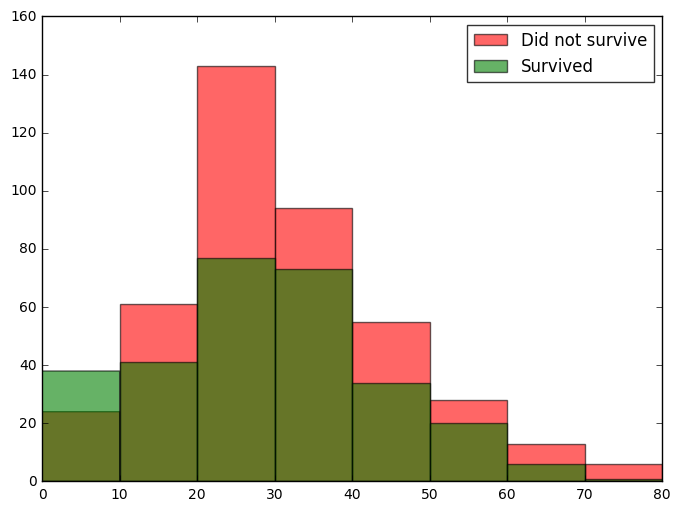

In [32]:
age_and_survival = train[["Age", "Survived"]]
age_and_survival = age_and_survival[~np.isnan(age_and_survival["Age"])]
age_and_survival["Age"].fillna(0)


min_age         = np.min(age_and_survival["Age"])
max_age         = np.max(age_and_survival["Age"])
age_value_range = max_age - min_age
bins            = np.arange(0, age_and_survival["Age"].max() + 10, 10)

nonsurv_vals    = age_and_survival[age_and_survival['Survived'] == 0]["Age"].reset_index(drop = True)
surv_vals       = age_and_survival[age_and_survival['Survived'] == 1]["Age"].reset_index(drop = True)
plt.figure(figsize=(8,6))

plt.hist(nonsurv_vals, bins = bins, alpha = 0.6, color = 'red', label = 'Did not survive')
plt.hist(surv_vals, bins = bins, alpha = 0.6, color = 'green', label = 'Survived')

# Add legend to plot
plt.xlim(0, bins.max())
plt.legend(framealpha = 0.8)

As we can see here, most of the people aged 0-20 years survived. Whilst your odds got a little bit worse after that, specially if you were in that 70+ year old range.

# Fitting a model, naively

Our data is already split into test/train - I'm going to now feed it to a random forest(set with a random depth) and test the accuracy of it using [R-squared](https://en.wikipedia.org/wiki/Coefficient_of_determination)

In [33]:
from sklearn.cross_validation import train_test_split

x_train, x_test, y_train, y_test = train_test_split(features, survived, test_size=0.2, random_state=6)

print("Data has been split!")

Data has been split!


**What exactly is a train test split?** [From the sklearn docs](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

It's just an utility function to split a set into training and test. Which is what I did to my `train` dataset.

The reason why I did this is because the actual `test` dataset is something that we're meant to benchmark against, and I wanted to be extra sure that the model at hand would never see that data first!

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import ShuffleSplit


regressor = DecisionTreeClassifier()
params    = { 'max_depth': range(1, 11) }
scorer    = make_scorer(r2_score)

# TODO use K-fold cross validation here
cv_sets   = ShuffleSplit(x_train.shape[0], n_iter = 10, test_size = 0.20, random_state = 10)

grid      = GridSearchCV(regressor, params, scoring=scorer, cv=cv_sets)

grid      = grid.fit(x_train, y_train)

estimator = grid.best_estimator_

print("The best depth for an optimal model is")
print(estimator.get_params()['max_depth'])

The best depth for an optimal model is
5


Now I'm going to do the same quantification that I did to my train set to the test set

In [35]:
test["Sex"] = test["Sex"].map({ 'female': 0, 'male': 1 })
test["Age"] = test["Age"].fillna(0)

print(test.head(10))

   PassengerId  Pclass                                          Name  Sex  \
0          892       3                              Kelly, Mr. James    1   
1          893       3              Wilkes, Mrs. James (Ellen Needs)    0   
2          894       2                     Myles, Mr. Thomas Francis    1   
3          895       3                              Wirz, Mr. Albert    1   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)    0   
5          897       3                    Svensson, Mr. Johan Cervin    1   
6          898       3                          Connolly, Miss. Kate    0   
7          899       2                  Caldwell, Mr. Albert Francis    1   
8          900       3     Abrahim, Mrs. Joseph (Sophie Halaut Easu)    0   
9          901       3                       Davies, Mr. John Samuel    1   

    Age  SibSp  Parch     Ticket     Fare Cabin Embarked  
0  34.5      0      0     330911   7.8292   NaN        Q  
1  47.0      1      0     363272  

In [37]:
passenger_ids   = np.array(test["PassengerId"]).astype(int)

# which are the same as I used before
target_features = test[relevant_features].values
prediction      = estimator.predict(target_features)
submission      = pd.DataFrame(prediction, passenger_ids, columns = ["Survived"])

print(submission)
print(submission.shape)

      Survived
892          0
893          0
894          0
895          0
896          0
897          0
898          0
899          0
900          0
901          0
902          0
903          0
904          1
905          0
906          1
907          1
908          0
909          0
910          0
911          0
912          0
913          1
914          1
915          0
916          1
917          0
918          1
919          0
920          0
921          0
...        ...
1280         0
1281         0
1282         0
1283         1
1284         0
1285         0
1286         0
1287         1
1288         0
1289         1
1290         0
1291         0
1292         1
1293         0
1294         1
1295         1
1296         0
1297         0
1298         0
1299         0
1300         1
1301         1
1302         1
1303         1
1304         0
1305         0
1306         1
1307         0
1308         0
1309         1

[418 rows x 1 columns]
(418, 1)


# TODO

- [ ] Write `submission.csv` file
- [ ] Use K-Fold cross validation to select a family of models, that are decision trees
- [ ] See if possible, use a [Random forest](https://en.wikipedia.org/wiki/Decision_tree_learning#Types)